## Bag of Words Meets Bags of Popcorn

# 튜토리얼 파트 3, 4

###  [Bag of Words Meets Bags of Popcorn | Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-3-more-fun-with-word-vectors)

* [DeepLearningMovies/KaggleWord2VecUtility.py at master · wendykan/DeepLearningMovies](https://github.com/wendykan/DeepLearningMovies/blob/master/KaggleWord2VecUtility.py)
* 캐글에 링크 되어 있는 github 튜토리얼을 참고하여 만들었으며 파이썬2로 되어있는 소스를 파이썬3에 맞게 일부 수정

In [1]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
import re
import numpy as np
import os

from nltk.corpus import stopwords
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 튜토리얼 파트2에서 사용한 코드를 가져옴
def review_to_wordlist(review, remove_stopwords=False):
    # 1. HTML 제거
    review_text = BeautifulSoup(review, "html.parser").get_text()
    # 2. 특수문자를 공백으로 바꿔줌
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자로 변환 후 나눈다.
    words = review_text.lower().split()
    # 4. 불용어 제거
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    # 5. Return a list of words
    return(words)


# 튜토리얼 파트2에서 사용한 코드를 가져옴
def review_to_sentences( review, remove_stopwords=False ):
    # punkt tokenizer를 로드한다.
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    # 1. nltk tokenizer를 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
    raw_sentences = tokenizer.tokenize(review.strip())
    # 2. 각 문장을 순회한다.
    sentences = []
    for raw_sentence in raw_sentences:
        # 비어있다면 skip
        if len(raw_sentence) > 0:
            # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

# centroid 는 두 클러스터의 중심점을 정의 한 다음 중심점의 거리를 측정한 것
def create_bag_of_centroids( wordlist, word_centroid_map ):
    
    # 클러스터의 수는 word / centroid map에서 가장 높은 클러스트 인덱스와 같다.
    num_centroids = max( word_centroid_map.values() ) + 1
    
    # 속도를 위해 bag of centroids vector를 미리 할당한다.
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    # 루프를 돌며 단어가 word_centroid_map에 있다면
    # 해당되는 클러스터의 수를 하나씩 증가시켜 준다.
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # bag of centroids를 반환한다.
    return bag_of_centroids

In [2]:
model = Word2Vec.load('300features_40minwords_10text')
model

In [3]:
type(model.wv.syn0)

numpy.ndarray

In [4]:
model.wv.syn0.shape

(12907, 300)

In [5]:
model.wv['flower'].shape

(300,)

In [6]:
model.wv['flower'][:10]

array([-0.10749114, -0.00965611, -0.06721605, -0.07270534, -0.04808562,
        0.04976285, -0.09057762,  0.01795127, -0.03035884, -0.03201051], dtype=float32)

In [7]:
# 단어 벡터에서 k-means를 실행하고 일부 클러스터를 찍어본다.
start = time.time() # 시작시간

# 클러스터의 크기 "k"를 어휘 크기의 1/5 이나 평균 5단어로 설정한다.
word_vectors = model.wv.syn0
num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)

# K means 를 정의하고 학습시킨다.
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# 끝난시간에서 시작시간을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  262.04898715019226 seconds.


In [8]:
# 각 어휘 단어를 클러스터 번호에 매핑되게 word/Index 사전을 만든다.
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫번째 클러스터를 출력
for cluster in range(0,10):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))
    
    # 클러스터번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['ms', 'marilyn', 'collins', 'monroe', 'christina', 'hurley']

Cluster 1
['domestic', 'marital', 'alcoholism']

Cluster 2
['hospital', 'accident', 'accidentally', 'conveniently', 'mysteriously', 'promptly', 'tables', 'inadvertently', 'unlucky', 'miraculously']

Cluster 3
['deliberately']

Cluster 4
['monotonous', 'tedium', 'aimless', 'unexciting', 'unfocused', 'disappointingly', 'uninvolving', 'vacant']

Cluster 5
['version', 'titles', 'versions']

Cluster 6
['opens', 'rain', 'staircase']

Cluster 7
['art', 'realism', 'artistic', 'daring', 'symbolism', 'authenticity', 'aesthetic', 'accessible', 'surrealism', 'sophistication', 'gloss']

Cluster 8
['influence', 'evolution', 'fascination', 'phenomenon', 'document', 'perception', 'academic', 'dependent', 'progressive', 'repression', 'societal']

Cluster 9
['vote', 'id', 'voted', 'voting', 'voters']


In [9]:
"""
판다스로 데이터프레임 형태의 데이터로 읽어온다.
QUOTE_MINIMAL (0), QUOTE_ALL (1), 
QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

그리고 이전 튜토리얼에서 했던 것처럼 clean_train_reviews 와 
clean_test_reviews 로 텍스트를 정제한다.
"""
train = pd.read_csv('data/labeledTrainData.tsv', 
                    header=0, delimiter="\t", quoting=3)
test = pd.read_csv('data/testData.tsv', 
                   header=0, delimiter="\t", quoting=3)
# unlabeled_train = pd.read_csv( 'data/unlabeledTrainData.tsv', header=0,  delimiter="\t", quoting=3 )


# 학습리뷰를 정제한다.
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

In [10]:
# 테스트 리뷰를 정제한다.
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

In [11]:
# bags of centroids 생성
# 속도를 위해 centroid 훈련 세트 bag을 미리 할당 한다.
train_centroids = np.zeros( (train["review"].size, num_clusters), \
    dtype="float32" )

train_centroids[:5]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [12]:
# 트레이닝 리뷰를 bags of centroids 로 변환한다.
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# 테스트 리뷰도 같은 방법으로 반복해 준다.
test_centroids = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1


# 랜덤포레스트를 사용하여 학습시키고 예측
forest = RandomForestClassifier(n_estimators = 100)

# train 데이터의 레이블을 통해 학습시키고 예측한다.
# 시간이 좀 소요되기 때문에 %time을 통해 걸린 시간을 찍도록 함
print("Fitting a random forest to labeled training data...")
%time forest = forest.fit(train_centroids, train["sentiment"])
%time result = forest.predict(test_centroids)

Fitting a random forest to labeled training data...
CPU times: user 34.9 s, sys: 176 ms, total: 35.1 s
Wall time: 35.2 s
CPU times: user 1.26 s, sys: 16.3 ms, total: 1.28 s
Wall time: 1.28 s


In [13]:
# 결과를 csv로 저장
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("data/BagOfCentroids.csv", index=False, quoting=3)

Wrote BagOfCentroids.csv


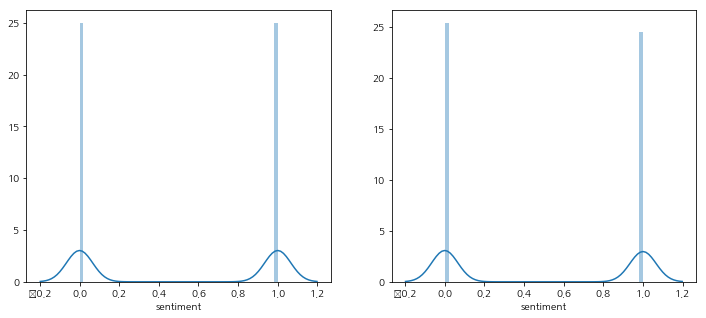

In [14]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(train['sentiment'], ax=axes[0], bins=50)
sns.distplot(output['sentiment'], ax=axes[1], bins=50)